# Desafio de Programação 7: Modelagem de um Sistema de Comunicação RF com Autoencoder em Pytorch

Neste desafio, serão introduzidos os conceitos iniciais sobre Autoencoder, abordando-se a modelagem de um sistema de comunicação em um canal AWGN.

## Identificação:

**Nome:Marcus Emanuel Carvalho Tenedini de Freitas**

**Matrícula:222025960**

## 1. Objetivo

O objetivo deste desafio é introduzir a ideia do Autoencoder, mostrando-se uma aplicação na área de telecomunicações.

Nesta aplicação, será implementada uma rede Autoencoder para realizar a codificação de símbolos enviados em um canal com ruído branco aditivo gaussiano *(Additive White Gaussian Noise - AWGN)*, gerando uma constelação própria.

Ao final, os resultados obtidos utilizando-se o Autoencoder serão comparados com o desempenho do detector ótimo, com a finalidade de equiparar a taxa de erro dos dois sistemas.



## 2. Preparação do Ambiente

Todas as informações necessárias para resolver este desafio de programação estão neste ambiente e todas as partes do código devem ser implementadas ao longo deste notebook.

Antes de iniciarmos, precisa-se que algumas bibliotecas já estejam disponíveis. São elas:

- Numpy: (http://www.numpy.org/) para todas as operações matriciais;
- Matplotlib: (https://matplotlib.org/) para a plotagem dos gráficos;
- Scipy: (https://docs.scipy.org/doc/scipy/reference/) que contém funções e ferramentas de cálculo numérico e científico;
- Pytorch: (https://pytorch.org/docs/stable/index.html) que disponibiliza diversas funções que simplificam a criação de um modelo de inteligência artificial, acelerando a elaboração dos códigos.

Para configurar o ambiente, será necessário permitir o acesso ao seu Google Drive, de onde serão importados os datasets, além de outros módulos adicionais.


A célula abaixo irá "montar" o drive dentro do Google Colaboratory, ou seja, conseguiremos acessar diretamente todos os conteúdos presentes no Google drive, possibilitando a execução do *Jupyter Notebook* a partir, unicamente, da nuvem.

In [10]:
#allows the drive to be accessed
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
import sys

!cat '/content/drive/MyDrive/TopEng/DP7/utils_exp2.py'
sys.path.append('/content/drive/MyDrive/TopEng/DP7')

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch

# work with math and erfc
import math
from scipy.special import erfc

from pylab import *
from sklearn.manifold import TSNE

# Função Q(x)
def func_q(x):
    return (1/2)*erfc((1/math.sqrt(2))*x)

# Detector ótimo para os esquemas tradicionais de modulação
def genareteBER(M, EbNodB_range):
    # gera o vetor de BER para cada uma das modulações tradicionais: M-ASK, M-PSK e M-QAM para 
    # uma dada lista de SNRs
    m_ask = [None]*len(EbNodB_range)
    m_psk = [None]*len(EbNodB_range)
    m_qam = [None]*len(EbNodB_range)
    for n in range(0,len(EbNodB_range)):
        EbNo=10.0**(EbNodB_range[n]/10.0)
        m_ask[n] = 2*(1-(1/M))*func_q((math.sqrt((6*math.log2(M))/(M**2-1)*EbNo)))
        m_psk[n] = 2*func_q(math.sin(math.pi/M)*math.sqrt(2*math.log2(M)*EbNo))
        

Com o acesso permitido ao drive e com o ambiente preparado, podemos iniciar a importação das bibliotecas de Python que serão utilizadas no nosso código.


In [12]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# work with math and erfc
import math
from scipy.special import erfc

# aditional modules for vizualisation
from pylab import *
from sklearn.manifold import TSNE

# complementary functions
import utils_exp2

Antes de iniciarmos a implemetação do código de fato, vamos verificar se há alguma GPU disponível para rodar os códigos, com o intuido de tornar mais rápido o treinamento da DNN.

In [13]:
train_on_gpu = torch.cuda.is_available() #Check if the GPU is available
if train_on_gpu: #if yes
    device = torch.device('cuda') #Select device as GPU
    print("Treinando na GPU.")
else: #Se não
    device = torch.device('cpu') #Select device as CPU
    print("GPU indisponível, treinando na CPU.")

Treinando na GPU.


## 3. Introdução Teórica

### 3.1 *Sistema de Comunicação*

Um Sistema de Comunicação é formado por módulos que atuam na formatação do sinal que será transmitido e no modo que o sinal recebido será interpretado. Na figura abaixo observamos um diagrama com os módulos que compõem o sistema de comunicação: no transmissor, temos os processos de *codificação* e *modulação*; enquanto no receptor há os blocos de *demodulação* e *decodificação*.

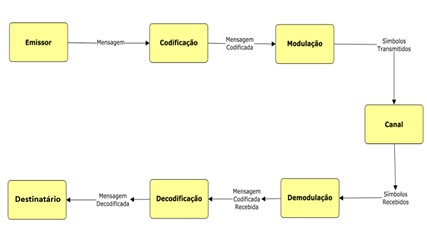

O *canal* (ou canal de comunicação, ou ainda meio de comunicação) representa o caminho físico pelo qual a mensagem sai do transmissor e chega ao receptor, formando assim um enlace de comunicação, seja ele um fio (par trançado ou de cobre), fibra óptica e até mesmo o próprio ar. A partir do canal de comunicação estabelecido, o engenheiro responsável projeta o sistema de comunicação para atender aos requisitos da comunicação e das adversidades impostas pelas condições físicas do canal (como atenuações e interferências).

Para sistemas de comunicação sem fio, o meio físico é o ar, assim o sinal transmitido sofre alterações oriundas do canal, como interferências (de outros sinais na mesma frequência), múltiplos percursos, o ruído, a atenuação e até mesmo o efeito Doppler (caso seja um dispositivo móvel).

Para tal, existem os blocos de *codificação* e *modulação* no transmissor que têm por objetivo encontrar a melhor representação do **sinal transmitido**, de modo que no receptor há os blocos de *demodulação* e *decodificação* para que se possa desfazer o que a codificação e a modulação (somado ao canal) fizeram ao **sinal original**.

Sabendo das adversidades impostas pelo canal de comunicação as técnicas de **modulação** visam a encontrar a melhor representação para o sinal, representação essa que o sinal suporte ser transmitido pelo canal até o receptor, isto é, encontrar um formato para que o sinal possa ser transmitido pelo canal até o receptor e, ao ser recebido, possa ser demodulado e decodificado com eficácia.

Já a **codificação** foca em encontrar o melhor código que represente o sinal mensagem, um código que se possa determinar se uma mensagem foi corrompida ou não e, em alguns casos, que seja possível até encontrar o erro e poder corrigi-lo.

Logo, com a codificação e a modulação, o sinal mensagem original é alterado para que ele possa ser transmitido e suporte as adversidades impostas pelo canal. De tal modo que os blocos de **demodulação** e **decodificação** vão desfazer o que foi feito nos blocos anteriores para que se possa completar a comunicação.

Se pensarmos no sistema de comunicação como um único bloco, uma caixa preta, podemos dizer que o transmissor emite a mensagem $M$ e o que sai do receptor é uma reconstrução da mensagem original que passou pelo sistema $\widehat{M}$, como podemos observar na figura abaixo.

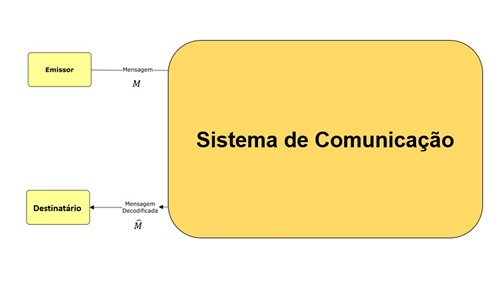

A técnica de modulação M-QAM mapeia os sinais mensagens em pontos de um espaço vetorial de duas dimensões (diagrama de estados), em que cada ponto é formado por uma tupla que representa os sinais em fase e em amplitude.

Na imagem abaixo temos a constelação para o 4-QAM. Assim, o ponto (-1,-1) representa a mensagem {00}, o ponto (-1,1) representa a mensagem {01}, o ponto (1,1) representa a mensagem {11} e o ponto (1,-1) representa a mensagem {10}. No mundo digital, trabalhamos com bits (representações binárias), de modo que para cada ponto temos 2 bits, ou seja, cada tupla representa um conjunto de 2 bits, e com dois bits é possível se ter 4 sinais mensagens distintos, logo temos  $M=2^{k}$ sinais mensagens, com $k$ sendo o número de bits.

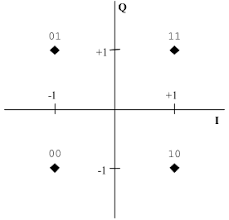

Como mais um exemplo, segue a imagem da Constelação do 16-QAM, assim, $M=16$ e $k=4$. Observam-se aqui alguns pontos relevantes sobre a ordem da modulação $M$:

*   Quanto maior o $M$, maior é a ordem da modulação;
*   Cada ponto no espaço representa $k$ bits;
*   A taxa de transmissão, bits por segundo [bps], aumenta de acordo com o $k$, desde que o tempo para se transmistir uma mensagem fique inalterado com a variação desse parâmetro;
*   Quanto maior o $M$, menor a distância entre os pontos, supondo-se inalterada a energia média de símbolos, aumentando-se assim a vulnerabilidade do sinal a ruído e interferência.




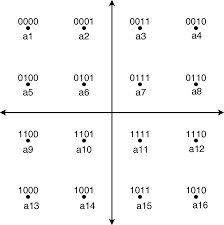

Conhecer o canal de comunicação é extremamente importante para, por meio da modulação e da codificação, podermos adaptar o sinal mensagem de tal forma que se possa completar o processo da comunicação com eficácia.

Como objetivo, geralmente, os sistemas de comunicação são projetados para se obter a menor taxa de erro possível. Logo, quanto menos se errar, melhor será a comunicação e a mesma será mais efetiva. Assim, um indicador bastante utilizado para caracterizar os sistemas de comunicação é a curva de taxa de erro de bit, do inglês *Bit Error Rate* (BER), ou ainda as curvas de *Block Error Rate* (BLER), que representa a taxa de erro de blocos de bits transmitidos.

Tais curvas são apresentadas em um gráfico Mono-Log, em que, no eixo Y, se tem a taxa de erro para determinada relação sinal-ruído, em Decibéis [dB], expressa no eixo X.

Convenciona-se neste notebook a SNR como dado na expressão $E_{b}/N_{0}$, ou seja, usaremos estes termos de forma análoga. De forma simplificada, para sistemas de comunicações digitais, consideramos a energia média de bit $E_{b}$ e a potência do ruído $N_{0}$, como medidas da relação entre a energia do sinal transmitido e a energia do ruído do sistema, a SNR.

Na imagem abaixo temos as curvas teóricas de BER para alguns sistemas de comunicação com modulação M-QAM. Notam-se dois pontos chaves, o primeiro é que, quanto maior é a relação sinal-ruído, menores são as taxas de erros, ou seja, quanto maior a penergia do símbolo transmitido e menor a energia do ruído menos se erra no sistema. O segundo ponto é que quanto maior é a ordem de modulação $M$ maiores são os requisitos de $E_{b}/N_{0}$, ou seja, para uma taxa de erro fixa (pegue $10^{-2}$, por exemplo), maiores são os valores de relação sinal-ruído de acordo com o aumento do $M$.

Pensando nos requisitos como potência, a relação sinal-ruído do canal, a taxa de transmissão em [bps] e a taxa de erro exigida pode-se determinar o melhor esquema de modulação M-QAM para o sistema de comunicação em questão.

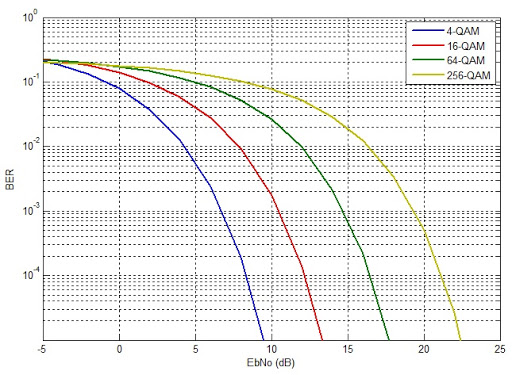

### 3.2 *O Autoencoder* (AE)

O Autoencoder é uma técnica de *machine learning* que utiliza redes neurais para montar um único sistema formado por uma rede neural que realiza a codificação (o encoder) e outra rede neural para a decodificação (o decoder) de uma dada entrada.

O foco do Autoencoder está na representação dos dados de entrada pelo encoder e na capacidade de reconstrução dos dados de entrada pelo decoder a partir da representação gerada. Um exemplo de utilização do Autoencoder é na redução de dimensionalidade de imagens, ou mesmo na exploração e determinação de features (certas características e/ou informações) das imagens.

Na figura a abaixo vemos um exemplo de utilização do autoencoder. Temos como entrada uma imagem que representa o número dois, ao passar pelo encoder ele gera uma nova representação da imagem. Em seguida, coloca-se essa representação comprimida na entrada do decoder para que ele reconstrua a imagem original.





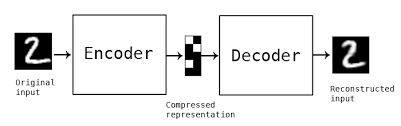

De acordo com (Ian Goodfellow, 2016), o Autoencoder é uma rede neural que é treinada para tentar copiar as entradas na saída, e em que internamente tem-se uma camada escondida denominada $h$ que codifica os dados de entrada em uma nova representação.

A rede neural é constituída de duas partes, o encoder que codifica os dados de entrada definido como $h = f(x)$ e o decoder que reconstrói nos dados originais a partir da representação estabelecida, definido como $r = g(h)$, obtendo-se assim a arquitetura apresentada na figura abaixo.

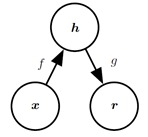

Assim, para que o autoencoder tenha sucesso basta aprender $g(f(x)) = x$ para qualquer valor de entrada $x$ treinado. Este modelo de rede neural prioriza as principais características da entrada na nova representação.

Chama-se *espaço latente* o espaço de codificação gerado pelo encoder. Seja $M$ a quantidade de elementos na entrada do encoder e $n$ a quantidade de elementos na saída do encoder temos duas situações para os autoencoders:


*   Se $M > n$: temos um autoencoder **subcomplete**, ou seja, a quantidade de elementos do espaço de representação, o espaço latente, é menor do que a quantidade de elementos da entrada.
*   Se $M < n$: temos um autoencoder **overcomplete**, ou seja, a quantidade de elementos do espaço de representação, o espaço latente, é maior do que a quantidade de elementos da entrada.

Na imagem abaixo podemos observar uma arquitetura para o autoencoder.



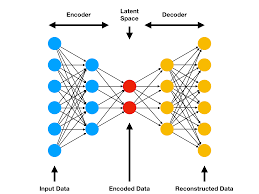

# 4. Autoencoder aplicado ao Sistema RF

Para superar as adversidades intrínsecas ao canal, os módulos que compõem o sistema de comunicação podem ser analisados e aperfeiçoados de forma individual. Nesse processo, destacam-se os processos de codificação e modulação dos sinais (mensagens/símbolos), uma vez que, juntos, eles objetivam encontrar a melhor representação dos símbolos a serem transmitidos no canal de comunicação.

Para além das técnicas convencionais, baseadas nos modelos estatísticos do canal, técnicas apoiadas em aprendizado de máquina estão ganhando cada vez mais espaço no campo das telecomunicações, e uma aplicação bastante estudada atualmente é a utilização de tais técnicas de aprendizado de máquina para se determinar a melhor representação dos símbolos de transmissão.

Logo, podemos atribuir ao Autoencoder a responsabilidade de encontrar a melhor representação dos sinais mensagens para um dado modelo de canal!


### 4.1 Considerações

Aqui vamos fazer algumas considerações sobre o problema e como adaptar um sistema de comunicação à estrutura do autoencoder apresentada.

**1)** A quantidade de **usos do canal**, definida como $n$. Cada mensagem possui determinado intervalo de tempo em que ela tem os recursos do canal disponíveis para que ela possa ser transmitida, e isso será feita na forma de $n$ símbolos em série no tempo (usos do canal).

**2)** O modelo de canal utilizado neste experimento será o AWGN, assim, o sinal recebido será modelado da seguinte forma: $y = x + r$, em que $y$ é o sinal recebido, $x$ o símbolo transmitido em cada uso do canal e $r$ o ruído que será uma variável aleatória gaussiana com média zero e variância $\sigma^2$.

**3)** A variância utilizada para modelar o ruído AWGN. Sabe-se que $\sigma^2 = N_{0}/2$ e definindo $R = k/n$ como a taxa de bits por usos do canal, chegamos a solução fechada para o desvio padrão do ruído:
$$\sigma = \sqrt{\frac{1}{2* R * \tfrac{E_{b}}{N_{0}}}}$$

**4)** Para a notação e arquitetura do autoencoder, utilizaremos a notação $AE(n,k)$, em que $n$ é a quantidade de usos do canal para transmissão e $k$, a quantidade de bits do sinal mensagem. Observa-se que para este sistema temos $M=2^k$ mensagens possíveis, e cada mensagem será transmitida na forma de $n$ símbolos.

**5)** Para cada mensagem $s \in M$, nós codificaremos a mensagem $s$ em um one-hot vector. A representação de one-hot vector estabelece que apenas uma posição (pode ser a coluna ou a linha) seja igual a 1 e o resto igual a 0, ou seja, podemos mapear um sinal mensagem '0110' no one-hot vector '0100'.

A arquitetura de rede neural utilizada neste experimento segue na imagem abaixo. Primeiro iremos mapear as $M$ mensagens (que é da forma $M$x$1$) em uma matriz $M$x$M$, em que cada linha represente uma mensagem e as colunas sejam a representação no formato one-hot vector.

Para um vetor one-hot como entrada iremos passar uma rede neural e em seguida por uma camada de normalização, de modo que será obtido $x$. Assim, adicionaremos o ruído com média zero e variância $\sigma^2$ já definida gerando o sinal $y$, e esse sinal somado ao ruído passará por mais uma camada de rede neural, em que na última camada teremos uma função de ativação $softmax$.

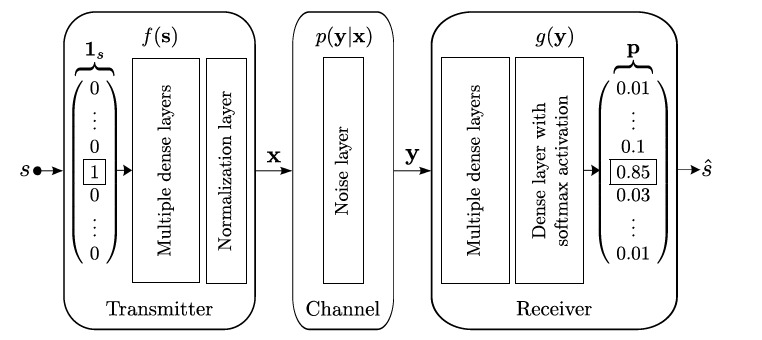

### 4.2 Criação do Modelo

A Classe do Autoencoder é estruturada no modelo a seguir.

Observa-se que para a criação desta classe precisa-se de duas informações:
- A primeira é a quantidade de mensagens $M$.
- A segunda é o tamanho do espaço latente definida pela variável **n_net**.

Dentro da função *forward* destacamos alguns processos:
- O primeiro é a normalização euclidiana aplicada. Esta normalização é referente às restrições de potência/energia ao sinal.
- O segundo é a criação do ruído pela função *torch.normal*, em que se necessita da taxa de bits/usos do canal $R$ e da relação sinal-ruído $E_{b}/N_{0}$.

Foram criadas as funções *auto_encoder* e *auto_decoder* para futuras referências, uma vez que a função *forward* é dedicada ao treinamento da rede neural.

No código a seguir, sua missão é escrever os cógidos nos campos indicado por **"..."** e esta parte do desafio vale **30,0 pontos**.

In [183]:
# Definição da Classe Autoencoder
class autoencoder(nn.Module):
    def __init__(self,M,n_channel,n_simbolos):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M,n_channel*n_simbolos, bias=True),
            nn.ReLU(True),
            nn.Linear(n_channel*n_simbolos,n_channel*n_simbolos,bias=True),
            nn.BatchNorm1d(n_channel*n_simbolos,affine=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_channel*n_simbolos, M,bias=True),
            nn.ReLU(True),
            nn.Linear (M, M),
            nn.ReLU(True),
            nn.Softmax()
        )

    def forward(self, x, R, n_channel,n_simbolos ,EbN0):
        outs = {}
        # Número de linhas de x
        x_size = x.shape[0]

        # Encoder Layer
        x = self.encoder(x)
        # Normalização Euclidiana
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*math.sqrt(n_channel)
        # Saída do vetor de codificado e normalizado
        outs['encoded'] = x

        # Channel Influence
        # Cria-se o vetor de ruído
        noise_channel = torch.normal(0.0, math.sqrt(1/(2*R*(10.0**(EbN0/10.0)))),[x_size, n_channel*n_simbolos])
        # Influencia do Canal - Soma com o ruído
        x = x + noise_channel
        # Saída do vetor de com ruído
        outs['encoded_noise'] = x

        # Decoder Layer
        x = self.decoder(x)
        # Saída do vetor de decodificado
        outs['decoded'] = x
        return outs

    def auto_encoder(self, x, n_channel,n_simbolos):
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*math.sqrt(n_channel)
        return x

    def auto_decoder(self, x):
        x = self.decoder(x)
        return x

#### 4.2.1 Paramêtros do Autoencoder

Primeiro vamos definir os parâmetros para construção da rede. Iremos treinar o modelo de autoencoder AE(2,2), em que $n=2$ e $k=2$, assim temos $M=4$ e uma taxa de bits por uso do canal igual 1 ($R=1$).

Como $M=4$ podemos mapear as mensagens da seguinte forma:
*   Mensagem 0 (00) -> 0001 na forma de one-hot vector;
*   Mensagem 1 (01) -> 0010 na forma de one-hot vector;
*   Mensagem 2 (10) -> 0100 na forma de one-hot vector;
*   Mensagem 3 (11) -> 1000 na forma de one-hot vector;

Ressalta-se que $n=2$ significa que usaremos o canal duas vezes (dois símbolos) para transmitir uma única mensagem. Para uma dada mensagem, o encoder irá gerar a seguinte representação: $encoder(M_i) => (x^{(i)}_{In_{1}}, x^{(i)}_{Qn_{1}}),(x^{(i)}_{In_{2}}, x^{(i)}_{Qn_{2}})$, ou seja, para $i$ = 1, 2, ..., $M$, entraremos com o one-hot vector da mensagem $M_i$ e o encoder gerará um vetor da forma 2*$n$x1 (lembre-se que estamos trabalhando com símbolos complexos que possuem o sinal em fase e em quadratura), assim teremos na saída do encoder um vetor na forma 4x1, em que, no primeiro uso do canal, enviaremos os dois componentes do primeiro símbolo, $(x^{(i)}_{In_{1}}, x^{(i)}_{Qn_{1}})$, e, no segundo uso do canal, enviaremos os dois componentes do segundo símbolo $(x^{(i)}_{In_{2}}, x^{(i)}_{Qn_{2}})$.

In [184]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 3

# Número de usos do canal
n_channel = 1

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2


#### 4.2.2 Criação do Modelo

Aqui criamos o modelo baseado nos dados configurados.

In [185]:
# Criação do Autoencoder
model = autoencoder(M,n_channel,n_simbolos)


### 4.3 Treinamento do Autoenoder

#### 4.3.1 Paramêtros de Treinemanto do Autoencoder

Sinta-se livre para testar todas as combinações possíveis e que lhe forem convenientes para o treinamento. Nesta parte do desafio, a definição de **learning_rate** e de **num_epochs** vale **40,0 pontos**.

In [187]:
# Parametros de treinamento
# Taxa de aprendizado
learning_rate = 0.005

# Quantidade de épocas de treinamento
num_epochs = 2000

# Tamanho do conjunto de cada treinamento - batch size
batch_size = 10*M

# Qunatidade de amostras de treinamento
N_treino = batch_size*10

O dataset, seja de treino ou de teste, para o nosso problema pode ser criado a maneira que foi definido os parâmetros anteriores.

Como precisamos da representação one-hot vector dos sinais mensagens utilizou-se a função *torch.eye()* para gerar uma matriz identidade, $I_M$, para as $M$ mensagens possíveis.

No entanto, queremos um dataset de treino do tamanho de **N_treino** (parâmetro este definido previamente). Assim, utiliza-se a função *torch.repeat()* que vai repetir a matriz identidade $I_M$ gerada **N_treino**/$M$ vezes. De modo que no fim teremos um dataset com **N_treino** amostras no formato one-hot vector.



In [188]:
# Montagem do dataset de treino
train_dataset = torch.eye(M)
data = train_dataset.repeat(int(N_treino/M),1)

#### 4.3.2 Rotina de Treinamento

Para o treinamento usaremos a função de Cross-Entropy para calcular o erro obtido entre a reconstrução do decoder e o sinal transmitido. Usaremos o algoritmo Adam para atualização dos pesos das redes neurais.

Repare que estamos utilizando a função *DataLoader* para formatar os nosso dataset, passamos como parâmetros os dados gerados, o tamanho do batch size que utilizaremos e habilitamos a função *shuffle* que fará o embaralhamento desses dados.

Note também que criamos uma variável para armazenar o erro a cada época para que ao final possamos plotar o gráfico de Loss x Epoch.

No código a seguir, sua missão é escrever os cógidos nos campos indicado por **"..."** e esta parte do desafio vale **20,0 pontos**.

In [189]:
# Treinamento do AE

# Função de perda do treinamento
criterion = nn.CrossEntropyLoss()

# Algortimo de otimização
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Para guardar os valores de loss
loss_epoch = []

for epoch in range(num_epochs):
    # Definição do dataset (aleatório para cada época)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

    # Para cada batch size em 'dataloader'
    for input_in in dataloader:
        # ===================forward=====================
        # Codificação do sinal de entrada
        output = model(input_in,R,n_channel,n_simbolos,EbN0)
        # Formatação dos dados para comparação na função de custo
        target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
        # Cross-Entropy Loss
        loss = criterion(output['decoded'], target_crossEntropy)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch.append(loss.data)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data))

epoch [1/2000], loss:2.0725
epoch [2/2000], loss:2.0638
epoch [3/2000], loss:2.0632
epoch [4/2000], loss:2.0653
epoch [5/2000], loss:2.0494
epoch [6/2000], loss:2.0226
epoch [7/2000], loss:2.0271
epoch [8/2000], loss:2.0297
epoch [9/2000], loss:1.9909
epoch [10/2000], loss:1.9200
epoch [11/2000], loss:1.9796
epoch [12/2000], loss:1.9677
epoch [13/2000], loss:1.8744
epoch [14/2000], loss:1.9145
epoch [15/2000], loss:1.9007
epoch [16/2000], loss:1.7654
epoch [17/2000], loss:1.8076
epoch [18/2000], loss:1.8463
epoch [19/2000], loss:1.8030
epoch [20/2000], loss:1.7928
epoch [21/2000], loss:1.8374
epoch [22/2000], loss:1.7781
epoch [23/2000], loss:1.7615
epoch [24/2000], loss:1.7806
epoch [25/2000], loss:1.7897
epoch [26/2000], loss:1.7936
epoch [27/2000], loss:1.7752
epoch [28/2000], loss:1.7482
epoch [29/2000], loss:1.8082
epoch [30/2000], loss:1.7980
epoch [31/2000], loss:1.7779
epoch [32/2000], loss:1.6944
epoch [33/2000], loss:1.7825
epoch [34/2000], loss:1.7522
epoch [35/2000], loss:1

### 4.4 Teste do Autoencoder

Além da fase de treinamento existem as fases de validação e teste. Em geral a fase de validação é utilizada para determinação da acurácia do modelo e análise dos paramêtros da rede, porém iremos direto para a fase de teste para podermos avaliar alguns outros aspectos do funcionamento do autoencoder.

Obs.: aconselha-se que após a leitura de todo o jupyter notebook o aluno volte à fase de treinamento e implemente o loop de validação e gere a curva de acurácia com os dados obtidos.

#### 4.4.1 Paramêtros de Teste do Autoencoder

Tal qual fizemos para o treinamento, repetiremos o processo de geração do dataset para o teste. Primeiro definimos a quantidade de amostras de teste, **N_teste**, em seguida utilizamos a função *torch.randint* para gerar valores aleatórios de 0 até M-1, assim usaremos tais valores como *labels* posteriormente. E por fim transformamos os valores da labels em one-hot vectors.

Note que treinamos o nosso autoencoder para um valor específico de $E_b/N_0$, agora queremos testar esse mesmo autoencoder para vários valores de relações sinal-ruído diferentes, e para isso criaremos um vetor para guardar os valores de BER.

In [191]:
# Parametros do modelo de Autoencoder

# Paramêtros de Teste
N_teste = 100000*M
test_label = torch.randint(0, M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()

# Variáveis de teste
EbNodB_range = torch.arange(0,8,0.5)
ber = [None]*len(EbNodB_range)

#### 4.4.2 Rotina de Teste

Nesta fase iremos apenas testar o modelo de autoencoder treinado para diferentes valores de $E_b/N_0$, assim teremos diferentes valores de $\sigma^2$, gerando diferentes dispersões dos valores de ruído, ou seja, testaremos o autoencoder para diferentes tipos de canais AWGN.

De modo geral, vamos primeiramente embaralhar os dados de teste, em seguida separá-los novamente em labels e dados de teste. Agora utilizaremos às funções *auto_encoder* e *auto_decoder*, definidas previamente, para codificar, adicionar o ruído gerado e decodificar. Após a decodificação transformamos o vetor de saída em uma lista e utilizamos a função *np.argmax()* que retorna o valor da posição em que há o maior valor na lista de entrada.

Por fim comparamos os resultados de saída com as labels iniciais, pela comparação realizada busca-se os valores diferentes, ou seja, os que não batem, transformando-se o vetor no formato booleano ('True' ou 'False') em um vetor de 0's e 1's e soma-se os valores iguais a 1 para se determinar a taxa de erro de bits.

In [192]:
# Teste do modelo treinado e cálculo da BER
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo)).item()
    noise_mean = 0.0
    no_errors = 0
    noise = torch.normal(noise_mean, noise_std,[N_teste, n_channel*n_simbolos])

    # Embaralhamneto do dataset de teste
    data = TensorDataset(test_data, torch.LongTensor(test_label))
    dataloader_test = DataLoader(data, batch_size=N_teste, shuffle=True)

    # Dividindo o dataset em labels e dados
    test_data_ = dataloader_test.dataset.tensors[0]
    label_ = np.array(dataloader_test.dataset.tensors[1])

    # Codificação do sinal
    encoded_signal = model.auto_encoder(test_data_, n_channel,n_simbolos)

    # Influencia do Canal
    channel_signal = encoded_signal + noise

    # Decodificação do sinal
    pred_final_signal = model.auto_decoder(channel_signal)
    parse_pred_output = pred_final_signal.tolist()
    pred_output = np.argmax(parse_pred_output,axis=1)   #retorna um array com a posição de maior argumento

    # Calculo da BER
    no_errors = (pred_output != label_)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / N_teste
    print ('SNR:',EbNodB_range[n].item(),'BLER:',ber[n], 'no_errors:',no_errors)

SNR: 0.0 BLER: 0.35166625 no_errors: 281333
SNR: 0.5 BLER: 0.3236925 no_errors: 258954
SNR: 1.0 BLER: 0.2960975 no_errors: 236878
SNR: 1.5 BLER: 0.26927 no_errors: 215416
SNR: 2.0 BLER: 0.2421525 no_errors: 193722
SNR: 2.5 BLER: 0.21429375 no_errors: 171435
SNR: 3.0 BLER: 0.18912375 no_errors: 151299
SNR: 3.5 BLER: 0.163955 no_errors: 131164
SNR: 4.0 BLER: 0.14080875 no_errors: 112647
SNR: 4.5 BLER: 0.1179775 no_errors: 94382
SNR: 5.0 BLER: 0.09880625 no_errors: 79045
SNR: 5.5 BLER: 0.080795 no_errors: 64636
SNR: 6.0 BLER: 0.06405 no_errors: 51240
SNR: 6.5 BLER: 0.0496075 no_errors: 39686
SNR: 7.0 BLER: 0.03804875 no_errors: 30439
SNR: 7.5 BLER: 0.0276925 no_errors: 22154


### 4.5 Gráficos de Resultados

#### 4.5.1 Gráfico de Loss

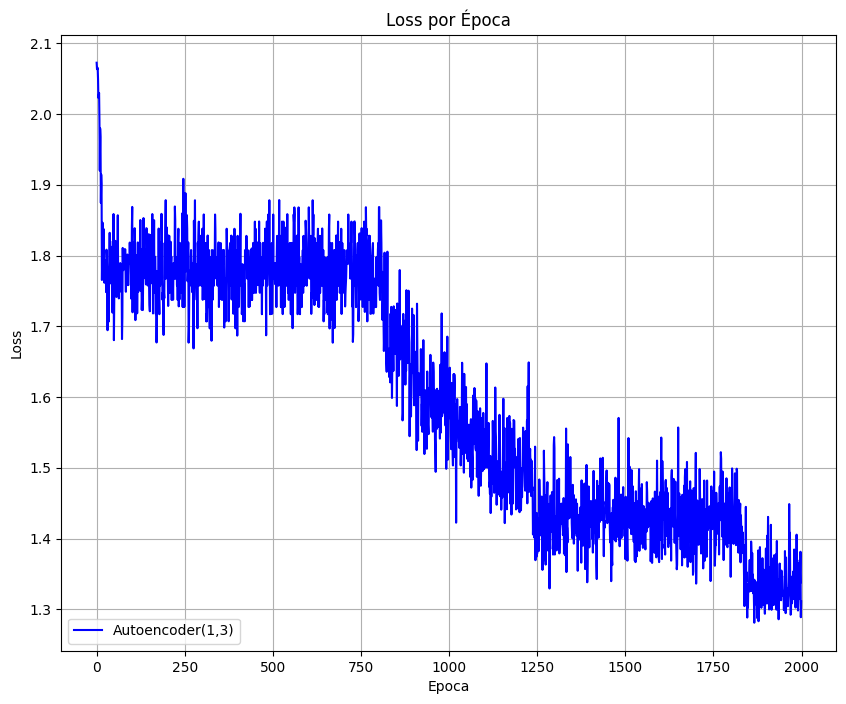

In [190]:
# Plot da curva de Loss
vector_loss = np.arange(0,len(loss_epoch),1)
fig = plt.figure(figsize=(10,8))
plt.plot(vector_loss,loss_epoch,'b',label='Autoencoder(%d,%d)'%(n_channel, k))
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Loss por Época')
plt.legend(loc='lower left',ncol = 1)
plt.grid()
plt.show()

#### 4.5.2 Gráfico de BLER
Sua missão é conseguir um resultado de BLER com Autoencoder melhor do que o resultado das técnicas convencionais e esta parte do desafio vale **10,0 pontos**.

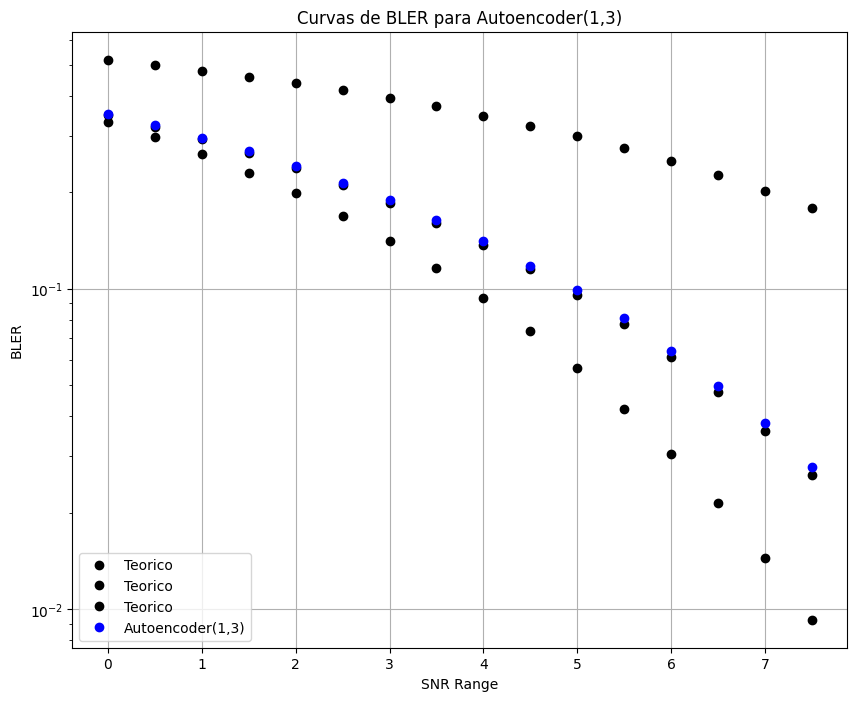

In [193]:
# Plot da curva de BER

# Curvas do detector ótimo
#-- Gera as curvas téoricas para as moduações ASK, PSK e QAM para um dado M e intervalos de SNR
ask_M, psk_M, qam_M = utils_exp2.genareteBER(2**k, EbNodB_range)

fig = plt.figure(figsize=(10,8))
fig_title = "Curvas de BLER para Autoencoder("+str(n_channel)+","+str(k)+")"
plt.plot(EbNodB_range, ask_M, 'ko',label='Teorico')
plt.plot(EbNodB_range, qam_M, 'ko',label='Teorico')
plt.plot(EbNodB_range, psk_M, 'ko',label='Teorico')
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(%d,%d)'%(n_channel, k))
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('BLER')
plt.title(fig_title)
plt.grid()
plt.legend(loc='lower left',ncol = 1)
plt.show()
#plt.savefig(fig_name)

#### 4.5.3 Gráfico da Constelação

<Figure size 640x480 with 0 Axes>

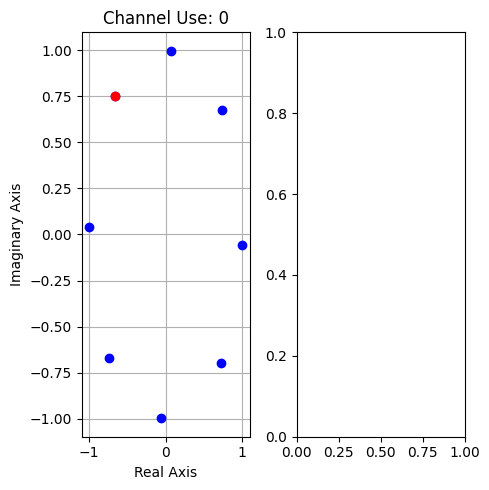

In [194]:
# Mensagens codigicadas pelo Encoder
data_encoded_symbol = model.auto_encoder(torch.eye(M),n_channel,n_simbolos)

# Separação dos símbolos em real e imaginário
real_symb, imag_symb = utils_exp2.split_symb(data_encoded_symbol)

# Plotagem das constelações por uso do canal
utils_exp2.plot_graphs(real_symb.detach().numpy(),imag_symb.detach().numpy(),n_channel,sizefig=5)